# **A/B Testing User Engagement: Page Views & Time‑on‑Page Analysis**

<br></br>

A/B testing is a randomized experiment that compares two versions of a feature to determine which performs better on key metrics. It separates guessing from optimization by showing different variations to different users and measuring real behavioral outcomes like clicks, conversions, page views, or time spent. Companies use A/B testing to identify friction points, improve user experience, reduce bounce rates, make low‑risk incremental changes, and achieve statistically significant improvements that drive higher ROI and long‑term business growth. Time‑on‑page is a key metric for understanding how users engage with content and how design alterations influence their experience. It goes beyond tracking visit duration: it reflects  the depth and quality of engagement. Comparing two versions of a page helps teams identify which elements keep users engaged and encourage further exploration. This evidence‑driven approach supports more confident product decisions and ultimately leads to better user satisfaction and business outcomes.

This notebook will analyze an A/B test dataset containing user‑level information such as group assignment (A vs. B), page views, time spent on the page, conversion outcomes, device type, and geographic location.
The workflow starts by examining the distribution of engagement metrics across devices and regions. It then compares page views and time-on-page between the control and variants groups using visual and statistical methods. The findings are interpreted in a business context to highlight what the results suggest about user behavior and how UX teams could use this evidence to optimize performance.

[Sources](https://vwo.com/ab-testing/)

In [69]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind, mannwhitneyu

In [70]:
# Load dataset on Google Drive
file_id = '1eZZikW7gC4CXN1WWIPHsNEj0KAZ2g4C5'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url)

# Show first 5 rows
print(df.head())

   User ID Group  Page Views  Time Spent Conversion   Device          Location
0    14292     B           3         424         No   Mobile  Northern Ireland
1    11682     A           9         342         No   Mobile          Scotland
2    19825     A           2         396         No  Desktop  Northern Ireland
3    16080     B           4         318         No  Desktop             Wales
4    18851     A           1         338        Yes  Desktop          Scotland




---



# **Data Preprocessing & EDA**

In [71]:
# Check for missing values
print(df.isna().sum())

User ID       0
Group         0
Page Views    0
Time Spent    0
Conversion    0
Device        0
Location      0
dtype: int64


In [72]:
# Check for duplicates
print(df.duplicated().sum())

0


In [73]:
# Check data types
print(df.dtypes)

User ID        int64
Group         object
Page Views     int64
Time Spent     int64
Conversion    object
Device        object
Location      object
dtype: object


In [74]:
# Summary Statistics Function
def summarize_metric(df, metric, group_col="Group"):
    summary_stats = (
        df.groupby(group_col)[metric]
        .agg(["mean", "median", "std", "count"])
        .reset_index()
    )
    return summary_stats

In [75]:
# Summarize Time Spent metrics
summarize_metric(df, "Time Spent")

,Group,mean,median,std,count
0,A,241.733227,241.0,117.340026,2519
1,B,243.303910,244.0,119.193552,2481


In [76]:
# Summarize Page Views metrics
summarize_metric(df, "Page Views")

,Group,mean,median,std,count
0,A,7.581580,8.0,4.080066,2519
1,B,7.492946,8.0,3.963448,2481


<br></br>

### **User Engagment Distribution**

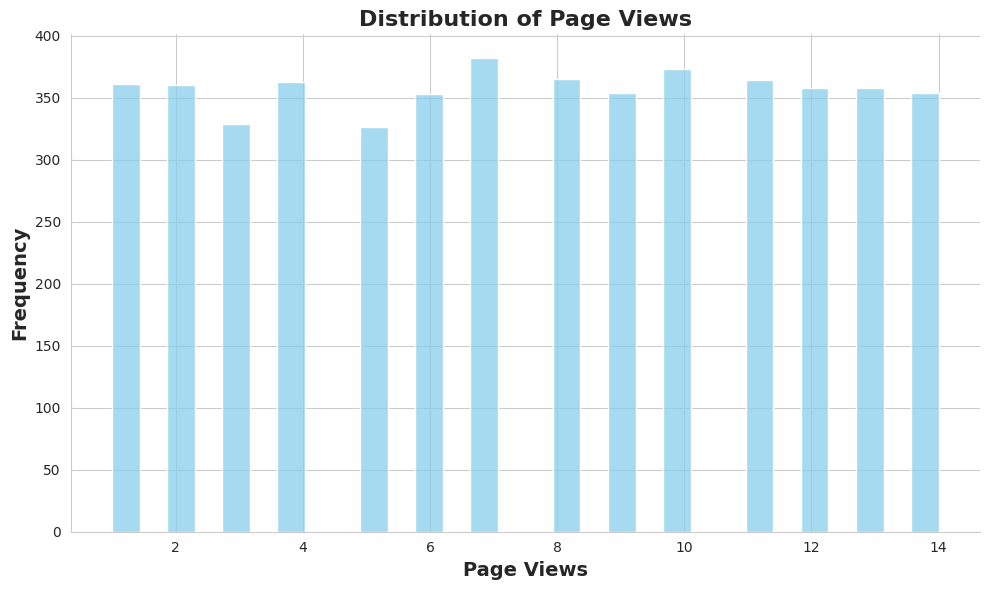

In [77]:
# Page Views histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['Page Views'], bins=30, color='skyblue')
plt.title('Distribution of Page Views', weight='bold', fontsize=16)
plt.xlabel('Page Views', weight='bold', fontsize=14)
plt.ylabel('Frequency', weight='bold', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

The histogram shows that page views are distributed fairly evenly, with no extreme spikes or drops across the range. Most values fall within a narrow frequency band, suggesting that users tend to view a similar number of pages. A small peak appears around seven page views, but the overall pattern remains stable. This uniform distribution provides a solid baseline for comparing engagement between the control and variant groups.

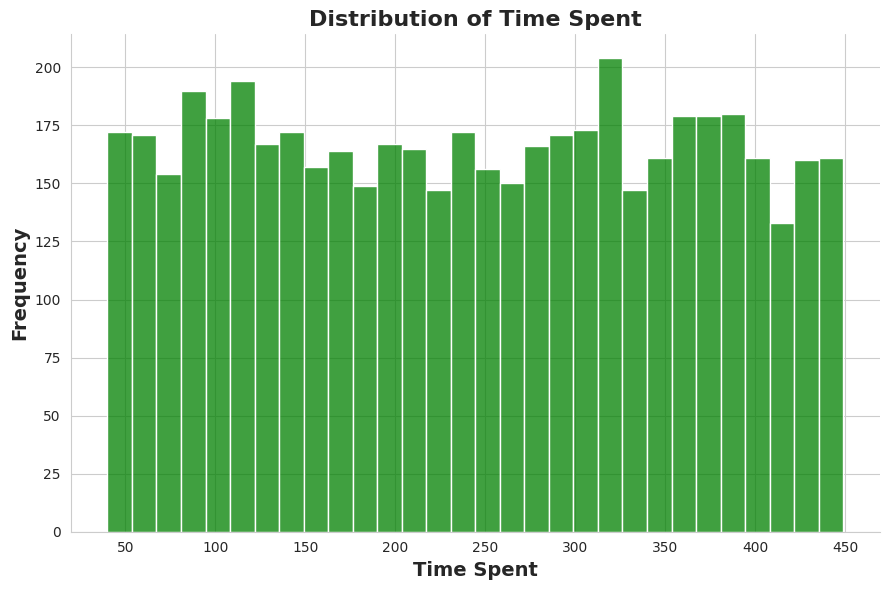

In [78]:
# Time Spent histogram
plt.figure(figsize=(9, 6))
sns.histplot(df['Time Spent'], bins=30, color='green')
plt.title('Distribution of Time Spent', weight='bold', fontsize=16)
plt.xlabel('Time Spent', weight='bold', fontsize=14)
plt.ylabel('Frequency', weight='bold', fontsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

The histogram shows that time spent on the page is spread fairly evenly across a wide range, with no extreme spikes or drop-offs. The highest frequency occurs around 325, suggesting that is it a common engagement duration. Overall, the distribution appears stable, making it also a reliable metric for comparing user behavior across groups.

<br></br>

### **Are the Two Groups (A and B) Similar in Size?**

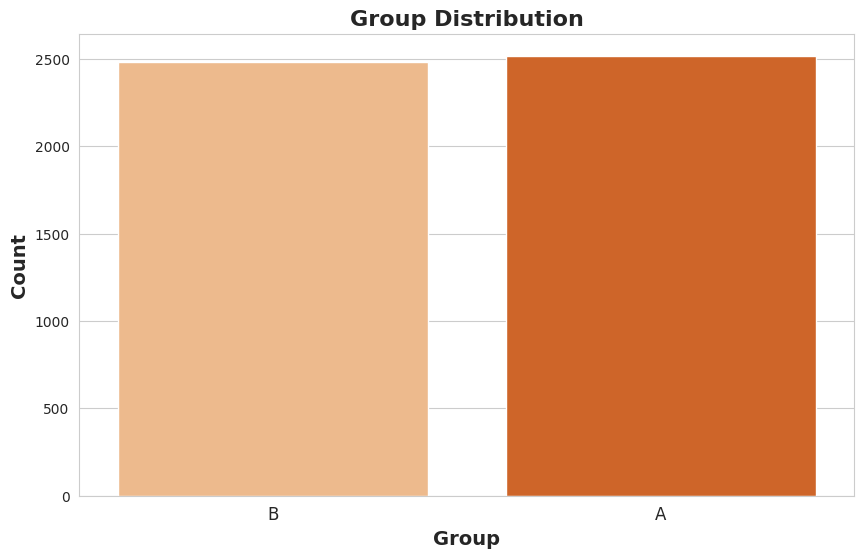

In [79]:
# Group barplot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.countplot(data=df, x='Group', hue='Group', legend=False, palette='Oranges')
plt.title('Group Distribution', weight='bold', fontsize=16)
plt.xlabel('Group', weight='bold', fontsize=14)
plt.ylabel('Count', weight='bold', fontsize=14)
plt.xticks(fontsize=12)
plt.show()

Group sizes are balanced.

<br></br>

### **How Time Spent and Page Views Vary by Device and Region?**

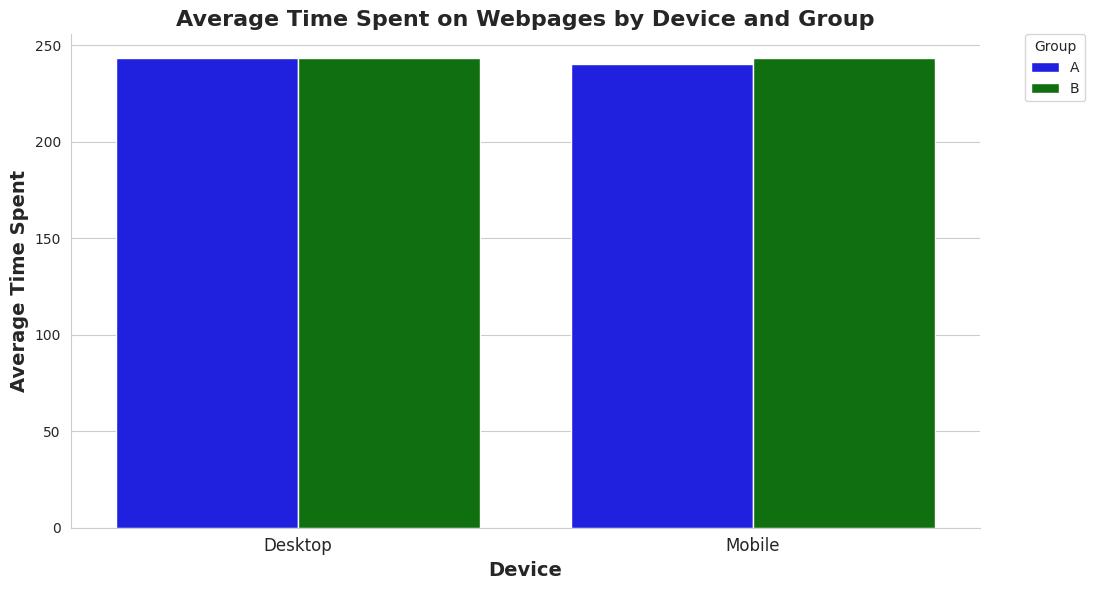

In [80]:
# Segment groups by device used
device_seg = df.groupby(['Group', 'Device']).agg({'Page Views': 'mean', 'Time Spent': 'mean'}).reset_index()

# Plot time spent
plt.figure(figsize=(10, 6))
sns.barplot(data=device_seg, x='Device', y='Time Spent', hue='Group', palette=['blue','green'])
plt.title('Average Time Spent on Webpages by Device and Group', weight='bold', fontsize=16)
plt.xlabel('Device', weight='bold',fontsize=14)
plt.ylabel('Average Time Spent', weight='bold',fontsize=14)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend( title="Group",bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

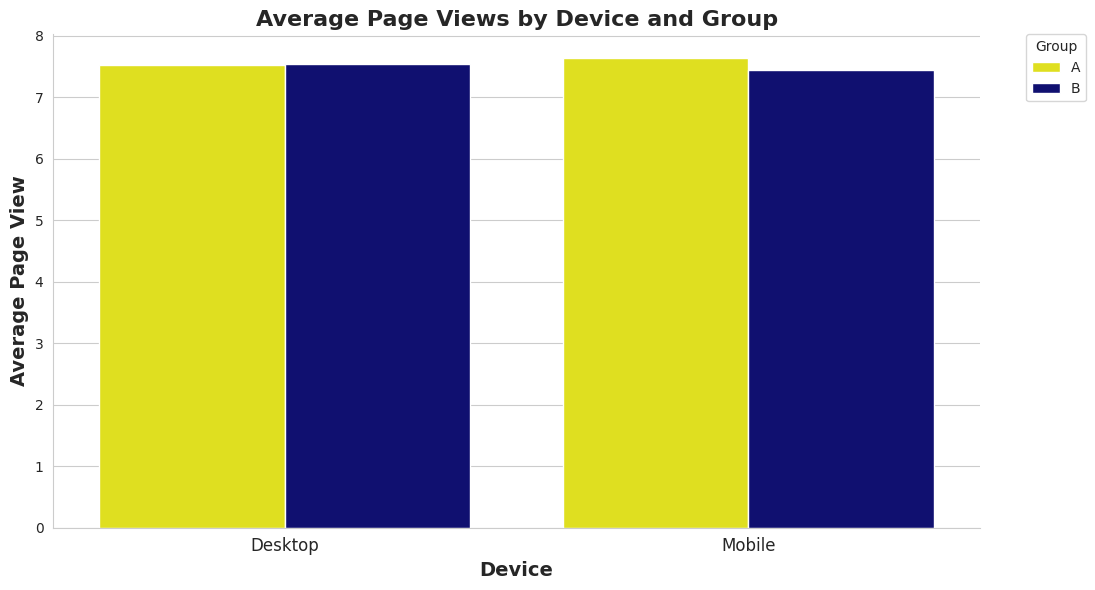

In [81]:
# Plot page views
plt.figure(figsize=(10, 6))
sns.barplot(data=device_seg, x='Device', y='Page Views', hue='Group', palette=['yellow','navy'])
plt.title('Average Page Views by Device and Group', weight='bold', fontsize=16)
plt.xlabel('Device', weight='bold', fontsize=14)
plt.ylabel('Average Page View', weight='bold', fontsize=14)
plt.xticks(fontsize=12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.legend( title="Group",bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

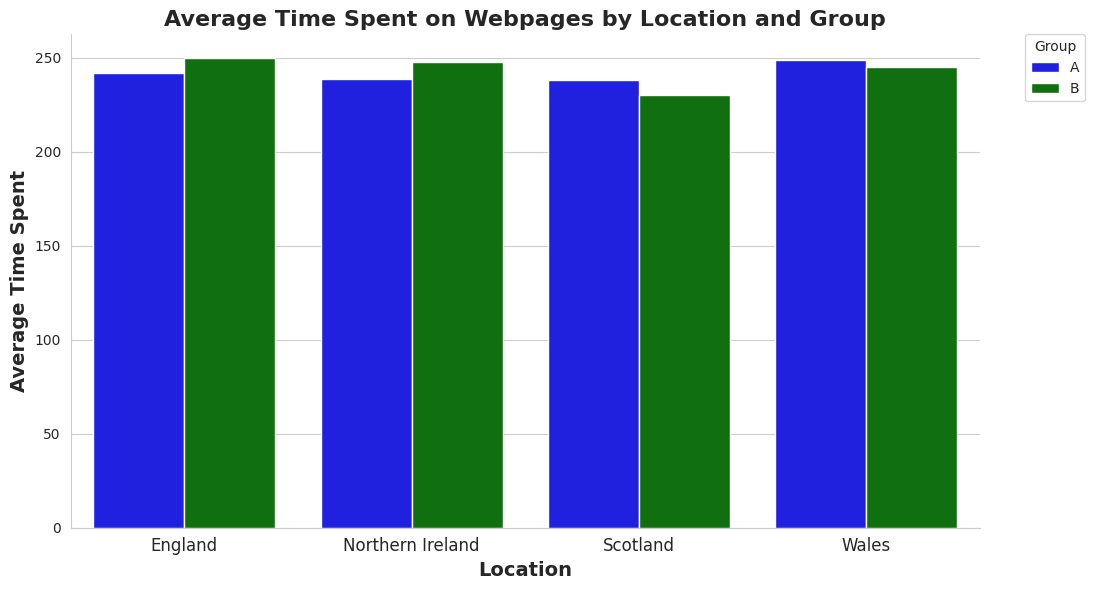

In [82]:
# Segment variants by location
loc_seg = df.groupby(['Group', 'Location']).agg({'Page Views': 'mean', 'Time Spent': 'mean'}).reset_index()

# Plot time spent
plt.figure(figsize=(10, 6))
sns.barplot(data=loc_seg, x='Location', y='Time Spent', hue='Group', palette=['blue','green'])
plt.title('Average Time Spent on Webpages by Location and Group', weight='bold', fontsize=16)
plt.xlabel('Location', weight='bold', fontsize=14)
plt.ylabel('Average Time Spent', weight='bold', fontsize=14)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend( title="Group",bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


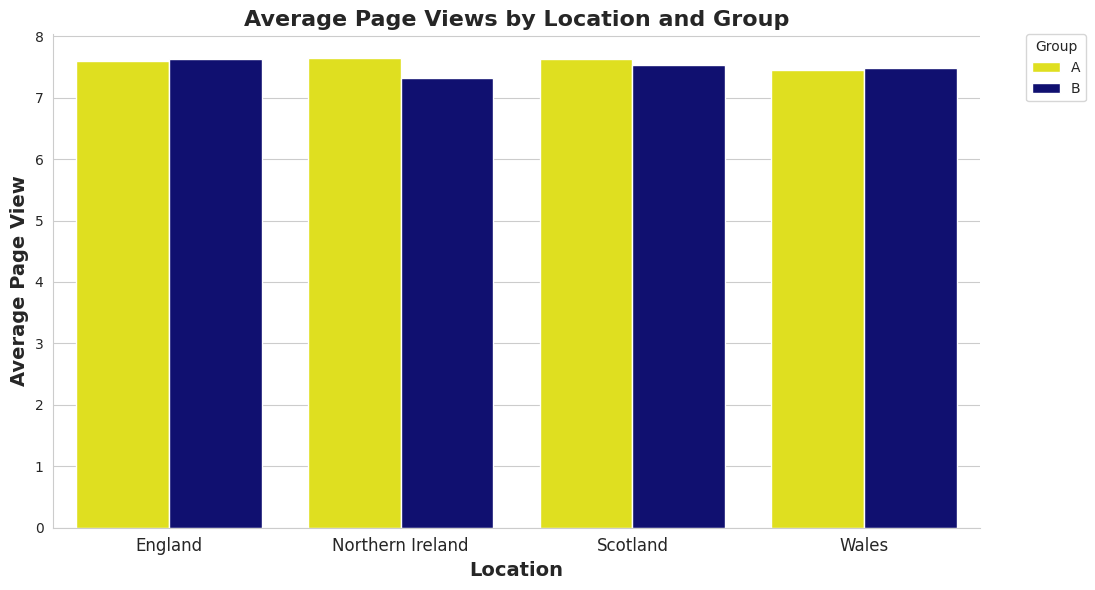

In [83]:
# Plot page views
plt.figure(figsize=(10, 6))
sns.barplot(data=loc_seg, x='Location', y='Page Views', hue='Group', palette=['yellow', 'navy'])
plt.title('Average Page Views by Location and Group', weight='bold', fontsize=16)
plt.xlabel('Location', weight='bold', fontsize=14)
plt.ylabel('Average Page View', weight='bold', fontsize=14)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend( title="Group",bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()



---



# **User Engagement Metric Significance Tests**

Variant B could boost conversions alone or increase both conversions and time spent, indicating deeper engagement. With engagement distributions appearing even and free of major outliers, statistical tests are required to verify whether the differences are meaningful.

Both a t‑test and a Mann‑Whitney U test can be used to validate whether the variant affects engagement metrics. The t‑test serves as the primary method given the large sample size and stable distributions, while the Mann‑Whitney U test provides a more robust check, especially when data is skewed with a small sample and not normally distributed. For this experiment, we will stick with the t-test.

In [84]:
# T‑Test / Mann‑Whitney
def run_stat_test(df, metric, group_col="Group", nonparametric=False):
    A = df[df[group_col] == "A"][metric]
    B = df[df[group_col] == "B"][metric]

    if nonparametric:
        stat, p = mannwhitneyu(A, B, alternative="two-sided")
        test_name = "Mann-Whitney U"
    else:
        stat, p = ttest_ind(A, B, equal_var=False)
        test_name = "T-test"
    test_summary = pd.DataFrame({
        "Test": [test_name],
        "Statistic": [stat],
        "p-value": [p]
    })

    return test_summary

In [85]:
# Test time spent difference for A vs. B
run_stat_test(df, "Time Spent")

,Test,Statistic,p-value
0,T-test,-0.469493,0.638738


In [86]:
# Test page views difference for A vs. B
run_stat_test(df, "Page Views")

,Test,Statistic,p-value
0,T-test,0.779161,0.435922


#### **Interpretating Significance Tests:**
Both metric (time‑spent and page‑views) show no statistically significant differences between Group A and Group B, indicating that the variant does not meaningfully alter engagement. Users spend similar amounts of time on the page and view a similar number of pages regardless of the version they see.



---



# **Conversion Results & Insights**



In [87]:
# Convert 'Conversion'column to 1 vs 0
df["Conversion"] = df["Conversion"].map({"Yes": 1, "No": 0})

In [88]:
# Two‑proportion z‑test for conversion
def run_conversion_test(df, conv_col="Conversion", group_col="Group"):
    conv = df.groupby(group_col)[conv_col].sum()
    samples = df.groupby(group_col)[conv_col].count()
    count = conv.values
    nobs = samples.values

    z_stat, p_value = proportions_ztest(count, nobs)

    # Conversion table
    results = pd.DataFrame({
        "Converted": conv,
        "Sample Size": samples,
    }).reset_index()

    # Summary with only z-statistic and p-value
    summary = (f"Z-statistic: {z_stat:.4f}\n" f"P-value: {p_value:.4f}")
    return results, summary

In [89]:
# Provide conversion and statistical results
results, summary = run_conversion_test(df, "Conversion", "Group")
print(results)
print()
print(summary)

  Group  Converted  Sample Size
0     A        136         2519
1     B        349         2481

Z-statistic: -10.3545
P-value: 0.0000


#### **Interpretation:**
The variant shows a substantially higher conversion count than the control (349 vs. 136), and the statistical test confirms that this difference is highly significant *(p-value < 0.001)*. This suggest the conversion difference is real and not driven by chance. Given Variant B superior performance, it should therefore be prioritized for implementation, as it delivers clear and statistically reliable improvement in user conversion behavior.

<br></br>

### **Visualize Variant B's Outstanding Performance**

---



/tmp/ipython-input-3108214797.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='Group', y="Conversion", errorbar=None, palette="Blues_r", edgecolor='white')


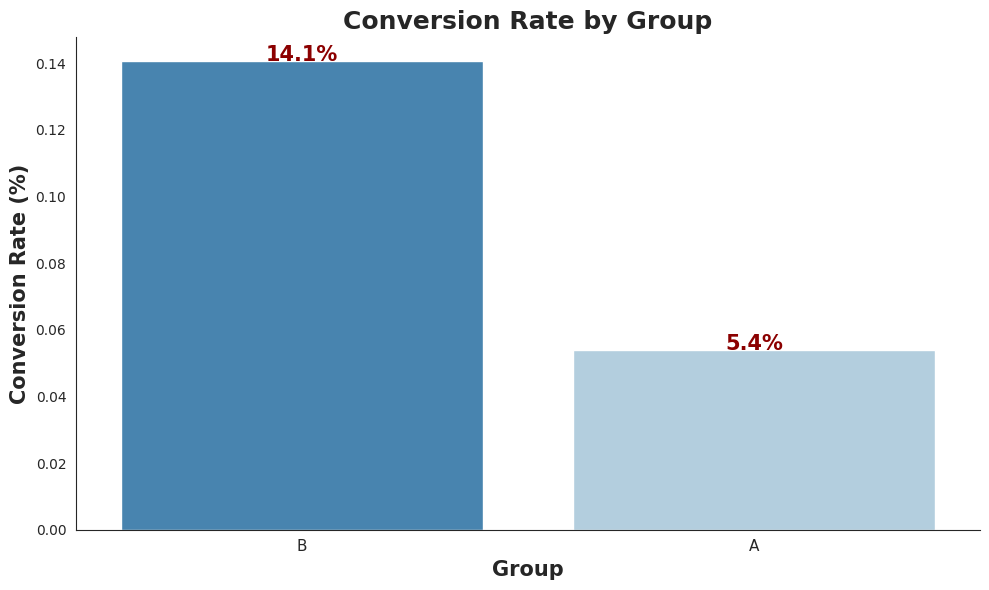

In [161]:
# Conversion rates per group
conv_rates = df.groupby("Group")["Conversion"].mean() * 100

# Barplot
sns.set_style("white")
plt.figure(figsize=(10,6))
ax = sns.barplot(data=df, x='Group', y="Conversion", errorbar=None, palette="Blues_r", edgecolor='white')
plt.title("Conversion Rate by Group", fontsize=18, weight="bold")
plt.xlabel("Group", fontsize=15, weight="bold")
plt.ylabel("Conversion Rate (%)", fontsize=15, weight="bold")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=11)
plt.tight_layout()

# Annotate barplot with conversion rate (%)
for i, label in enumerate(ax.get_xticklabels()):
    group = label.get_text()
    pct = conv_rates[group]
    ax.text(i, pct/100, f"{pct:.1f}%",
        ha='center', color='darkred',fontsize=15, weight='bold')
plt.show()

Not only the z-test proportion was statistically significant (p < 0.001), but also it's showing visually. Group A converts at 5.4%, while Variant B converts at a substantial 14.1%. This represents a large and meaningful improvement, with Variant B converting at more than 2.5 time the rate of the control group.



---



# **Segmentation Insights and Interaction Effects**


<br></br>

### **Z‑test**
#### Does the variant B work better on mobile vs. desktop?

In [93]:
devices = df["Device"].unique()

for d in devices:
    subset = df[df["Device"] == d]

    conv = subset.groupby("Group")["Conversion"].sum()
    nobs = subset.groupby("Group")["Conversion"].count()

    z, p = proportions_ztest(conv.values, nobs.values)

    print(f"\nDevice: {d}")
    print(f"Z-statistic: {z:.4f}, P-value: {p:.4f}")


Device: Mobile
Z-statistic: -7.8894, P-value: 0.0000

Device: Desktop
Z-statistic: -6.7607, P-value: 0.0000


### **Interpretation:**
Variant B significantly outperforms Variant A on both mobile and desktop devices. The extremely low p‑values (p < 0.001) indicate that the improvement holds up no matter what device people are using.

In [94]:
locations = df["Location"].unique()

for loc in locations:
    subset = df[df["Location"] == loc]

    conv = subset.groupby("Group")["Conversion"].sum()
    nobs = subset.groupby("Group")["Conversion"].count()

    z, p = proportions_ztest(conv.values, nobs.values)

    print(f"\nLocation: {loc}")
    print(f"Z-statistic: {z:.4f}, P-value: {p:.4f}")


Location: Northern Ireland
Z-statistic: -4.0994, P-value: 0.0000

Location: Scotland
Z-statistic: -6.1037, P-value: 0.0000

Location: Wales
Z-statistic: -6.0954, P-value: 0.0000

Location: England
Z-statistic: -4.3887, P-value: 0.0000


#### **Interpretation:**
Across Northern Ireland, Scotland, Wales, and England, Variant B consistently outperforms Variant A. The low p‑values (all p < 0.001) confirm that the marginal effect in conversion rates is highly significant everywhere, with no regional differences in performance.

<br></br>

## **Chi‑square test:**
#### Does device or location affect conversion at all?

In [95]:
# Device vs Conversion Chi2 test
cont_device = pd.crosstab(df["Device"], df["Conversion"])
chi2, p, dof, expected = chi2_contingency(cont_device)

print("Device vs Conversion")
print(f"Chi-square: {chi2:.4f}, P-value: {p:.4f}")

Device vs Conversion
Chi-square: 0.3642, P-value: 0.5462


In [96]:
# Location vs Conversion Chi2 test
cont_loc = pd.crosstab(df["Location"], df["Conversion"])
chi2, p, dof, expected = chi2_contingency(cont_loc)

print("\nLocation vs Conversion")
print(f"Chi-square: {chi2:.4f}, P-value: {p:.4f}")


Location vs Conversion
Chi-square: 4.9349, P-value: 0.1766


#### **Chi-square Result Interpretation:**
Neither device type nor geographic location shows a statistically significant relationship with conversion. The high p-values (Device p-value = 0.5462, Location p-value = 0.1766) indicate that conversion rates remain stable across both segments. In practical termss, there is no evidence that users convert differently based on their device or where they are located.



---



# **Logistic Regression**
####  Are there interaction effects between variant and segment?

In [97]:
# Logistic regression with variant/group * device interaction
model = smf.logit("Conversion ~ Group + Device + Group:Device", data=df).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.307281
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             Conversion   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4996
Method:                           MLE   Df Model:                            3
Date:                Thu, 01 Jan 2026   Pseudo R-squ.:                 0.03504
Time:                        04:09:08   Log-Likelihood:                -1536.4
converged:                       True   LL-Null:                       -1592.2
Covariance Type:            nonrobust   LLR p-value:                 4.972e-24
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -2.7752      0.121    -23.005      0.000   

#### **Result Interpretation:**
1. Consistent with above results, Variant B substantially increases the odds of conversion compared to Group A (p < 0.001)

2. Device type does not influence conversion (p = 0.304: not statistically significant), which means mobile and desktop users convert at similar rates.

3. No interaction between variant and device (p = 0.323). This means device type does not change the effect of the variant.

In [98]:
# Logistic regression with variant/group * location interaction
model2 = smf.logit("Conversion ~ Group + Device + Group:Location", data=df).fit()
print(model2.summary())

Optimization terminated successfully.
         Current function value: 0.306532
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             Conversion   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4991
Method:                           MLE   Df Model:                            8
Date:                Thu, 01 Jan 2026   Pseudo R-squ.:                 0.03740
Time:                        04:09:08   Log-Likelihood:                -1532.7
converged:                       True   LL-Null:                       -1592.2
Covariance Type:            nonrobust   LLR p-value:                 5.117e-22
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -2.5787      

### **Result Interpretation:**
1. Variant B has a strong, statistically significant positive effect (p < 0.001). This confirms that Variant B significantly increases the odds of conversion, even after controlling for device type and location. This aligns with the above z‑test results, reinforcing Variant B's real conversion impact.

2. Device type does not influence conversion (p = 0.714: not statistically significant), which means that both mobile and desktop users convert at similar rates.

3. No meaningful interaction between variant and location (all p‑values > 0.05), indicating that the effect of Variant B is stable across all four regions. In practical terms, no region responded differently to the variant.








---



# **Recommendation**

The results of the A/B test provide strong and consistent evidence that Variant B should be adopted as the new default experience. The variant delivers a substantial and statistically significant improvement in conversion, with p‑values well below 0.001 in the overall two‑proportion z‑test. This indicates that the causal effect is real, reliable, and not driven by random variation.

Segmentation analysis reinforces this conclusion. Variant B outperforms Variant A across every device type and every geographic region, with extremely low p‑values in all subgroups. This consistency shows that the improvement is not limited to a specific audience segment; the variant performs equally well for mobile and desktop users and across all four regions.

Additional statistical checks confirm the stability of this effect. Chi‑square tests show no significant relationship between conversion and either device type or location, indicating that these factors do not influence baseline conversion behavior. Logistic regression with interaction terms further supports this finding: neither device type nor region moderates the impact of the variant, and no interaction effects are statistically significant.

Notably, engagement metrics such as time spent and page views show no significant differences between groups. This suggests that Variant B's conversion impact is achieved without requiring deeper or longer engagement, likely reflecting more efficient design elements.

Overall, the findings point to Variant B being the stronger option. The data supports switching to Variant B for all users, as it boosts performance without introducing risks across different user groups.

<br></br>

## Presented by:
<a href= "https://www.linkedin.com/in/carllegros/" target="_blank"> Carl Legros </a>